# Multiword expressions identification and extraction

The task shows two simple methods useful for identifying multiword expressions (MWE) in corpora.

## Tasks

1. Use SpaCy [tokenizer API](https://spacy.io/api/tokenizer) to tokenize the text from the law corpus.

In [1]:
import locale
import os
import pickle

# python -m spacy download en_core_web_sm
# python -m spacy download pl_core_news_sm
import string
import tarfile
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import morfeusz2
import numpy as np
import pandas as pd
import regex
import spacy
from spacy.tokenizer import *
import math
import operator
import time
import Levenshtein
import pandas as pd
from PIL import Image


matplotlib.style.use("ggplot")
%matplotlib inline
locale.setlocale(locale.LC_COLLATE, "pl_PL.UTF-8")

'pl_PL.UTF-8'

2. Compute **bigram** counts of downcased tokens.  Given the sentence: "The quick brown fox jumps over the
   lazy dog.", the bigram counts are as follows:
   
   * "the quick": 1
   * "quick brown": 1
   * "brown fox": 1
   * . ...
   * "dog .": 1

In [2]:
nlp = spacy.load("pl_core_news_sm")
tokenizer = Tokenizer(nlp.vocab)

tokens = {}
tokens_list = []
i = 0
path = "../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
        act = file.read()
        act = regex.sub(r"\s+", " ", act)
        act = regex.sub(r"­", "", act)
        act = act.lower()
        words = [token.text for token in tokenizer(act)]
        tokens[file.name] = words
        tokens_list = tokens_list + words
        i += 1
        if i % 200 == 0:
            print(i)

old_tokens_list = tokens_list

200
400
600
800
1000


In [3]:
tokens_list[0:10]

[' ', 'dz.u.', 'z', '1998', 'r.', 'nr', '117,', 'poz.', '759', 'ustawa']

In [4]:
def sort_dict(dictionary):
    return dict(sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True))

In [5]:
def separate_puctuations(tokens):
    new_tokens = []
    for token in tokens:
        splitted = regex.findall(
            r"[\w']+|[.,!?;]", token
        )  # https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation
        new_tokens += splitted
    return new_tokens


tokens = ["new,", "fast,", "expensive"]
separate_puctuations(tokens) #splitting into words and punctuation example 

['new', ',', 'fast', ',', 'expensive']

In [6]:
def bigrams(words):
    words = list(map(lambda x: x.strip(), words))
    words = zip(words, words[1:])
    return [" ".join(pair) for pair in words]


text = "The quick brown fox jumps over the lazy dog."
words = [token.text for token in tokenizer(text)]
print(bigrams(words))

['The quick', 'quick brown', 'brown fox', 'fox jumps', 'jumps over', 'over the', 'the lazy', 'lazy dog.']


In [7]:
tokens_list = separate_puctuations(tokens_list)
gram2 = bigrams(tokens_list)

In [8]:
Counter(gram2).most_common(5)

[('art .', 83779),
 ('ust .', 53552),
 ('poz .', 45222),
 ('. 1', 43484),
 (', poz', 43192)]

   
3. Discard bigrams containing characters other than letters. Make sure that you discard the invalid entries **after**
   computing the bigram counts.
    

In [9]:
# data = gram2.filter()
gram2 = [
    token
    for token in gram2
    if all(char not in string.punctuation and not char.isdigit() for char in token)
]
Counter(gram2).most_common(5)

[('w art', 32045),
 ('mowa w', 28471),
 ('w ust', 23557),
 ('o których', 13885),
 ('których mowa', 13858)]

4. Use [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) to compute the measure 
   for all pairs of words. 

In [10]:
def to_probabilities(tokens):
    tokens_count = Counter(tokens)
    count = sum(tokens_count.values())
    return {k: v / count for k, v in tokens_count.items()}


p_bigram = to_probabilities(gram2)


p_token = to_probabilities(tokens_list)


In [11]:
def pmi(x, y):  # pointwise_mutual_information
    result = p_bigram[x + " " + y] / (p_token[x] * p_token[y])
    return math.log2(result)


gram2_pmi = {}
for key in gram2:
    if len(key.split()) > 2:
        print(key)
    gram2_pmi[key] = pmi(*key.split())

In [12]:
separate_puctuations(["tery­torialnego"]) 

['tery', 'torialnego']

5. Sort the word pairs according to that measure in the descending order and determine top 10 entries.

In [13]:
gram2_pmi = sort_dict(gram2_pmi)
list(gram2_pmi.items())[:10]

[('korzy stający', 23.024484997199306),
 ('gałki ocznej', 23.024484997199306),
 ('przedemery talne', 23.024484997199306),
 ('organa uchwałodawcze', 23.024484997199306),
 ('kropki wstawić', 23.024484997199306),
 ('antykonkurencyjnym koncentracjom', 23.024484997199306),
 ('skupiających kibiców', 23.024484997199306),
 ('chuli gańskich', 23.024484997199306),
 ('znająca pjm', 23.024484997199306),
 ('przyspo sobieniu', 23.024484997199306)]

In [14]:
# Unfortunatelly some words are separated by new line and it was not possible to merge them together "korzy" "stający"
"""             środków trwałych, jeżeli w umowie leasingu zastrzeżono, że korzy
             stający będzie ponosił ciężar tych podatków i składek niezależnie"""
old_tokens_list.index("korzy")
old_tokens_list[22536:22560]

['w',
 'umowie',
 'leasingu',
 'zastrzeżono,',
 'że',
 'korzy',
 'stający',
 'będzie',
 'ponosił',
 'ciężar',
 'tych',
 'podatków',
 'i',
 'składek',
 'niezależnie',
 'od',
 'opłat',
 'za',
 'używanie,',
 '3)',
 'kaucji',
 'określonej',
 'w',
 'umowie']

6. Filter bigrams with number of occurrences lower than 5. Determine top 10 entries for the remaining dataset (>=5
   occurrences).

In [15]:
gram2_count = Counter(gram2)

In [16]:
gram2_pmi5 = {k: v for k, v in gram2_pmi.items() if gram2_count[k] >= 5}
gram2_pmi5 = sort_dict(gram2_pmi5) 
list(gram2_pmi5.items())[:10]

[('obiegów chłodzących', 20.70255690231194),
 ('otworami wiertniczymi', 20.70255690231194),
 ('świeckie przygotowujące', 20.70255690231194),
 ('zaszkodzić wynikom', 20.70255690231194),
 ('teryto rialnego', 20.70255690231194),
 ('klęskami żywiołowymi', 20.70255690231194),
 ('metalizacji natryskowej', 20.70255690231194),
 ('natryskiwania tworzywami', 20.70255690231194),
 ('past emulsyjnych', 20.70255690231194),
 ('młynki młotkowe', 20.70255690231194)]

7. Use [log likelihood ratio](http://tdunning.blogspot.com/2008/03/surprise-and-coincidence.html) (LLR) to compute the measure
   for all pairs of words.

In [17]:
""" # How LLR algorithm should look like, but this implementation is too slow soo we should use another
def H(k):
    # print(k)
    N = np.sum(k)
    # print(N)
    # print(np.sum(k/N * np.ma.log(k/N).filled(0)))
    return np.sum(k/N * np.ma.log(k/N).filled(0))


def llr(a,b):

    k11 = gram2_count[a+' '+b]
    k12 = sum([count for key, count in gram2_count.items() if not a in key and b in key])
    k21 = sum([count for key, count in gram2_count.items() if a in key and not b in key])
    k22 = sum([count for key, count in gram2_count.items() if not a in key and not b in key])
    k = np.array([[k11,k12],[k21,k22]])
    rowSums = np.sum(k, axis=1).tolist()
    colSums = np.sum(k, axis=0).tolist()
    
    return 2* np.sum(k) * (H(k) - H(rowSums) - H(colSums))    


llr('w','art2')

bigram_llr =  {}
length = len(gram2)
i=0 
for key in gram2:
    if len(key.split())>2:
        print(key)
    bigram_llr[key] = llr(*key.split())
    if i%10==0:
        print(f'{i}/{length}')
    print(key,bigram_llr[key])
    i+=1
    
"""
None

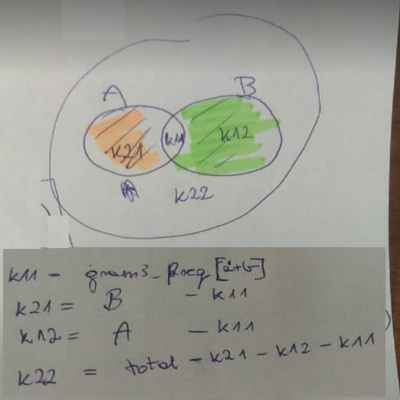

In [18]:

image = Image.open('1.png')
image =image.resize((400,400),Image.ANTIALIAS)
display(image)



In [19]:
from collections import defaultdict

token_count = defaultdict(int)

for bigram, count in gram2_count.items():
    (first_token, second_token) = bigram.split()
    token_count[first_token] += count
    token_count[second_token] += count

total = sum(gram2_count.values())

In [20]:
def H(k):
    N = np.sum(k)
    return np.sum(k / N * np.ma.log(k / N).filled(0))


def llr(a, b):

    k11 = gram2_count[a + " " + b]
    k12 = token_count[b] - k11
    k21 = token_count[a] - k11
    k22 = total - k21 - k12 - k11
    k = np.array([[k11, k12], [k21, k22]])
    rowSums = np.sum(k, axis=1).tolist()
    colSums = np.sum(k, axis=0).tolist()

    return 2 * np.sum(k) * (H(k) - H(rowSums) - H(colSums))


llr("w", "art")

72556.59014900832

In [21]:
gram2_llr = {}
length = len(gram2)
i = 0
for key in gram2:
    if len(key.split()) > 2:
        print(key)
    gram2_llr[key] = llr(*key.split())
    if i % (int(length / 10)) == 0:
        print(f"{i}/{length}")
    # print(key,gram2_llr[key])
    i += 1

0/2837496
283749/2837496
567498/2837496
851247/2837496
1134996/2837496
1418745/2837496
1702494/2837496
1986243/2837496
2269992/2837496
2553741/2837496
2837490/2837496


8. Sort the word pairs according to that measure in the descending order and display top 10 entries.

In [22]:
gram2_llr = sort_dict(gram2_llr)
list(gram2_llr.items())[:10]

[('otrzymuje brzmienie', 102885.48395536352),
 ('w w', 88950.24561342891),
 ('w art', 72556.59014900832),
 ('których mowa', 65874.30552844425),
 ('w ust', 59140.47968532207),
 ('o których', 52416.33194280648),
 ('mowa w', 51071.7654550929),
 ('drodze rozporządzenia', 45996.84967469449),
 ('dodaje się', 43483.15738019904),
 ('którym mowa', 42425.906420601474)]

In [23]:
gram2_llr5 = {k: v for k, v in Counter(gram2).items() if v >= 5}
gram2_llr5 = sort_dict(gram2_llr5)


9. Compute **trigram** counts for the whole corpus and perform the same filtering.

In [24]:
def trigrams(words):
    words = list(map(lambda x: x.strip(), words))
    words = zip(words, words[1:], words[2:])
    return [" ".join(pair) for pair in words]


text = "The quick brown fox jumps over the lazy dog."
words = [token.text for token in tokenizer(text)]
print(trigrams(words))

['The quick brown', 'quick brown fox', 'brown fox jumps', 'fox jumps over', 'jumps over the', 'over the lazy', 'the lazy dog.']


In [25]:
gram3 = trigrams(tokens_list)
gram3 = [
    token
    for token in gram3
    if all(char not in string.punctuation and not char.isdigit() for char in token)
]
# gram3 = [ k for k, v in Counter(gram3).items() if v>=5] # filter with treshold = 5 (minimum 5 occurrences of the phrase)

gram3_count = Counter(gram3)

10. Use PMI (with 5 occurrence threshold) and LLR to compute top 10 results for the trigrams. Devise a method for computing the values, based on the
   results for bigrams.

In [26]:
def to_probabilities(tokens):
    tokens_count = Counter(tokens)
    count = sum(tokens_count.values())
    return {k: v / count for k, v in tokens_count.items()}


p_gram3 = to_probabilities(gram3)

In [27]:
def pmi3(x, y, z):  # pointwise_mutual_information
    result = p_gram3[x + " " + y + " " + z] / (p_token[x] * p_token[y] * p_token[z])
    return math.log2(result)


gram3_pmi = {}
for key in gram3:
    if len(key.split()) != 3:
        print(key)
    gram3_pmi[key] = pmi3(*key.split())

In [28]:
gram3_pmi = sort_dict(gram3_pmi)
list(gram3_pmi.items())[:10]


[('pozyskać sortymentów drzewnych', 45.52475039226819),
 ('restytucji world jewish', 45.52475039226819),
 ('world jewish restitution', 45.52475039226819),
 ('jewish restitution organisation', 45.52475039226819),
 ('prosimy uważnie przeczytać', 45.52475039226819),
 ('uważnie przeczytać poniższą', 45.52475039226819),
 ('szyciem naciętego krocza', 45.52475039226819),
 ('ostrzeżony strzałami ostrzegawczymi', 45.52475039226819),
 ('ekstrakt ketobemidon cliradon', 45.52475039226819),
 ('karboksymetylo oksym dihydrokodeinonu', 45.52475039226819)]

In [29]:
gram3_count = Counter(gram3)
gram3_pmi5 = {k: v for k, v in gram3_pmi.items() if gram3_count[k] >= 5}
gram3_pmi5 = sort_dict(gram3_pmi5)


http://tdunning.blogspot.com/2008/03/surprise-and-coincidence.html
"Regarding trigrams, one of the easiest implementations is to simply make a pass looking for significant bigrams. Then, considering those bigrams as single words, make another pass looking for bigrams that include bigrams from the first pass. These composite bigrams are really trigrams. You can repeat this process as you like." Ted Dunning


In [30]:
from collections import defaultdict

token_count = defaultdict(int)


for trigram, count in gram3_count.items():
    (a, b, c) = trigram.split()
    first_token = a + " " + b
    second_token = b + " " + c
    token_count[first_token] += count
    token_count[second_token] += count

In [31]:
total = len(gram3)

print(total)

2353306


In [32]:
def H(k):
    # print(k)

    N = np.sum(k)
    # print(N)
    # print(np.sum(k/N * np.ma.log(k/N).filled(0)))
    return np.sum(k / N * np.ma.log(k / N).filled(0))


def llr3(a, b, trigram):

    k11 = gram3_count[trigram]
    k12 = token_count[b] - k11
    k21 = token_count[a] - k11
    k22 = total - k21 - k12 - k11
    k = np.array([[k11, k12], [k21, k22]])
    rowSums = np.sum(k, axis=1).tolist()
    colSums = np.sum(k, axis=0).tolist()

    return 2 * np.sum(k) * (H(k) - H(rowSums) - H(colSums))

In [33]:
gram3_llr = {}
length = len(gram3)
i = 0
for key in gram3:
    if len(key.split()) != 3:
        print(key)
    (word1, word2, word3) = key.split()

    first_token = f"{word1} {word2}"
    second_token = f"{word2} {word3}"

    gram3_llr[key] = llr3(first_token, second_token, key)

    if i % (int(length / 10)) == 0:
        print(f"{i}/{length}")
    # print(key,gram2_llr[key])
    i += 1


0/2353306
235330/2353306
470660/2353306
705990/2353306
941320/2353306
1176650/2353306
1411980/2353306
1647310/2353306
1882640/2353306
2117970/2353306
2353300/2353306


In [34]:
gram3_llr = sort_dict(gram3_llr)

In [35]:
gram3_count =Counter(gram3)
gram3_llr5 = {k: v for k, v in gram3_llr.items() if gram3_count[k] >= 5}
gram3_llr5 = sort_dict(gram3_llr5) 


11. Create a table comparing the methods (separate table for bigrams and trigrams).

In [36]:
df = pd.DataFrame({ # for bigrams
	'gram2_pmi' : list(gram2_pmi.items())[0:20], # pmi
    'gram2_pmi5' : list(gram2_pmi5.items())[0:20], # pmi filtered for words with at least 5 occurrences
    'gram2_llr' : list(gram2_llr.items())[0:20], # llr
    'gram2_llr5' : list(gram2_llr.items())[0:20] # llr filtered for words with at least 5 occurrences
    
})

df

,gram2_pmi,gram2_pmi5,gram2_llr,gram2_llr5
0,"(korzy stający, 23.024484997199306)","(obiegów chłodzących, 20.70255690231194)","(otrzymuje brzmienie, 102885.48395536352)","(otrzymuje brzmienie, 102885.48395536352)"
1,"(gałki ocznej, 23.024484997199306)","(otworami wiertniczymi, 20.70255690231194)","(w w, 88950.24561342891)","(w w, 88950.24561342891)"
2,"(przedemery talne, 23.024484997199306)","(świeckie przygotowujące, 20.70255690231194)","(w art, 72556.59014900832)","(w art, 72556.59014900832)"
3,"(organa uchwałodawcze, 23.024484997199306)","(zaszkodzić wynikom, 20.70255690231194)","(których mowa, 65874.30552844425)","(których mowa, 65874.30552844425)"
4,"(kropki wstawić, 23.024484997199306)","(teryto rialnego, 20.70255690231194)","(w ust, 59140.47968532207)","(w ust, 59140.47968532207)"
5,"(antykonkurencyjnym koncentracjom, 23.02448499...","(klęskami żywiołowymi, 20.70255690231194)","(o których, 52416.33194280648)","(o których, 52416.33194280648)"
6,"(skupiających kibiców, 23.024484997199306)","(metalizacji natryskowej, 20.70255690231194)","(mowa w, 51071.7654550929)","(mowa w, 51071.7654550929)"
7,"(chuli gańskich, 23.024484997199306)","(natryskiwania tworzywami, 20.70255690231194)","(drodze rozporządzenia, 45996.84967469449)","(drodze rozporządzenia, 45996.84967469449)"
8,"(znająca pjm, 23.024484997199306)","(past emulsyjnych, 20.70255690231194)","(dodaje się, 43483.15738019904)","(dodaje się, 43483.15738019904)"
9,"(przyspo sobieniu, 23.024484997199306)","(młynki młotkowe, 20.70255690231194)","(którym mowa, 42425.906420601474)","(którym mowa, 42425.906420601474)"


In [37]:
df = pd.DataFrame({ # for trigrams
	'gram3_pmi' : list(gram3_pmi.items())[0:20],
    'gram3_pmi5' : list(gram3_pmi5.items())[0:20],
    'gram3_llr' : list(gram3_llr.items())[0:20],
    'gram3_llr5' : list(gram3_llr5.items())[0:20]
    
})

df

,gram3_pmi,gram3_pmi5,gram3_llr,gram3_llr5
0,"(pozyskać sortymentów drzewnych, 45.5247503922...","(topienia żużla wielkopiecowego, 40.3548253908...","(o których mowa, 130326.30749652752)","(o których mowa, 130326.30749652752)"
1,"(restytucji world jewish, 45.52475039226819)","(porcelanowe młyny kulowe, 39.880894202493465)","(o którym mowa, 93966.98951460843)","(o którym mowa, 93966.98951460843)"
2,"(world jewish restitution, 45.52475039226819)","(wymienniki przeponowe rurowe, 39.48035627290974)","(mowa w ust, 80683.70742976072)","(mowa w ust, 80683.70742976072)"
3,"(jewish restitution organisation, 45.524750392...","(akumulatora ołowiowego kwasowego, 39.13243296...","(mowa w art, 70985.86883561742)","(mowa w art, 70985.86883561742)"
4,"(prosimy uważnie przeczytać, 45.52475039226819)","(partnerstwie publiczno prywatnym, 39.03932356...","(których mowa w, 69167.67451145055)","(których mowa w, 69167.67451145055)"
5,"(uważnie przeczytać poniższą, 45.52475039226819)","(rozdziałach xxxix xliv, 38.91004054815298)","(o której mowa, 61914.80145216781)","(o której mowa, 61914.80145216781)"
6,"(szyciem naciętego krocza, 45.52475039226819)","(marii curie skłodowskiej, 38.880894202493465)","(w drodze rozporządzenia, 55068.65940835584)","(w drodze rozporządzenia, 55068.65940835584)"
7,"(ostrzeżony strzałami ostrzegawczymi, 45.52475...","(finałowego turnieju mistrzostw, 38.3648790554...","(minister właściwy do, 47977.772785700996)","(minister właściwy do, 47977.772785700996)"
8,"(ekstrakt ketobemidon cliradon, 45.52475039226...","(profilem zaufanym epuap, 38.12387095598601)","(którym mowa w, 45011.20512861168)","(którym mowa w, 45011.20512861168)"
9,"(karboksymetylo oksym dihydrokodeinonu, 45.524...","(cienką sierścią zwierzęcą, 38.06531877363089)","(w ustawie z, 35392.380207012866)","(w ustawie z, 35392.380207012866)"


12. Answer the following questions:

   <b>a. Why do we have to filter the bigrams, rather than the token sequence?</b>
   
   Because otherwise, e.g. where is the end of the sentence we would get bigrams from the last word in the sentence and the first in the next sentence.
   Similarly for commas.
   
   <b>b. Which measure (PMI, PMI with filtering, LLR) works better for the bigrams and which for the trigrams?</b>
   <b>c. What types of expressions are discovered by the methods.</b>

   
   Generally in both cases PMI gives more interesting results. We can find there collocations like eg. "ostrzeżony strzałami ostrzegawczymi", "profilem zaufanym epuap", "centralnemu biuru antykorupcyjnemu". For trigrams pmi gives long latin names of substances, which probably occur in the text once. To prevent this behavior we can filter the bigrams which appear less than 5 times. After filtering in for bigrams as well as trigrams PMI provides better results
   
   PMI for bigrams sometimes returns "splitted words" e.g. when in the text of act in the middle of the word was '\n' sign. This problem is less visible for trigrams
   
   LLR promotes results with the words that are common in act's text like "minister właściwy do", "zastępuje się wyrazami". For my curiosity I tried to filter LLR with the same threshold that was used for pmi. The outputs are the same, so it makes no difference if we filter it or not 
   
   
   <b>d. Can you devise a different type of filtering that would yield better results?</b>
   
   One possibility is to filter stopwords like "i", "w", "na", "z" "jest". 
   
   We could also try to connect words splitted by new line / or filter them from bigram list
   
